In [60]:
import torch
from PIL import Image
import torchvision.io as io
import torchvision.transforms
import os
import matplotlib.animation
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

Import de Vidéo

In [137]:
dataset_dir = ".\\SomeEx"
video_files = [f for f in os.listdir(dataset_dir) if f.endswith('.mp4')]

videos = []
NbToLoad = 10

loadded = 0
for video_name in video_files:
    print("Loading",video_name)
    video, audio, info = io.read_video(dataset_dir + "/" + video_name, pts_unit='sec')
    videos.append(video)
    loadded += 1
    if (loadded >= NbToLoad):
        break
    
print("Done")

Loading actccqfmac.mp4
Loading agpzzhhprs.mp4
Loading balgkhiurl.mp4
Loading bgymmjkbec.mp4
Loading bkppzqmzdp.mp4
Loading cgjmjdenqi.mp4
Loading cjsopoykvh.mp4
Done


In [118]:
import torchvision.transforms as transforms


def ToPILImage(frame):
    return transforms.ToPILImage()(frame.numpy())

def ResizePIL(img, size):
    return img.resize((size, size*img.size[1]//img.size[0]), Image.Resampling.LANCZOS)

In [179]:
target_video = videos[4]

In [140]:
plt.ioff()
NbFrames = 10

fig, ax = plt.subplots()
def animate(t):
    plt.cla()
    plt.imshow(target_video[t])
matplotlib.animation.FuncAnimation(fig, animate, frames=NbFrames)

# img = ResizePIL(ToPILImage(target_video[t]),200)
# img = ToPILImage(target_video[t])


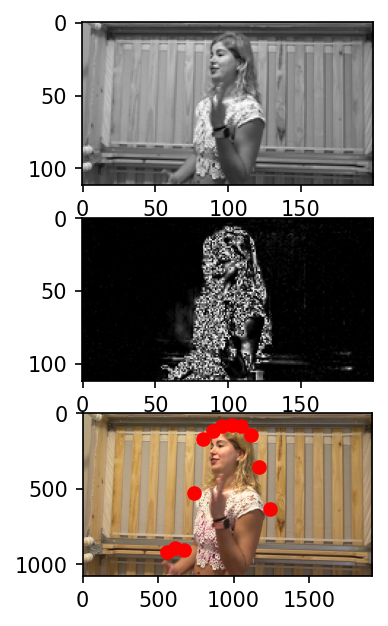

In [211]:
# Detect mouvement area

def sensing_fct(image):
    maxv = np.max(image)
    minv = np.min(image)
    seuil = int(minv+(maxv-minv)/2)
    #return np.clip(image, seuil, maxv)
    return np.where(image>seuil, 0,image)

def get_relevant_points(video, display=False):
    # Load Low quality
    rvideo = []
    LowQualitySize = 200

    for i in range(20):
        rvideo.append(np.array(ResizePIL(ToPILImage(video[i]), LowQualitySize).convert('L')))
    rvideo = np.array(rvideo)

    original_w, original_h = ToPILImage(video[0]).size

    def get_pos_hd(x, y):
        # Return pixel position in hd frame from ld coordonates
        return [int(x*(original_w/LowQualitySize)), int(y*original_h/(LowQualitySize*(original_h/original_w)))]

    # Get Mvt from start frame
    first_frame = rvideo[0]
    gap_frame = np.zeros_like(first_frame)

    for i in range(1,len(rvideo)):
        gap_frame += sensing_fct(np.abs(first_frame - rvideo[i]))

    if (display):
        plt.subplot(3,1,1)
        plt.imshow(rvideo[0], cmap='gray')
        plt.subplot(3,1,2)
        plt.imshow(gap_frame, cmap='gray')
        #plt.imshow(gap_frame, cmap='gray')
        plt.subplot(3,1,3)
        plt.imshow(ToPILImage(video[0]), cmap='gray')

    # Puis on se fait des bande verticales

    Nbandes = 30
    StdNormalisedNoMvt = 0.2

    def find_hit_y(x):
        # return the first place where mvt
        slice = gap_frame[:,x]
        max_slice = np.max(slice)
        min_slice = np.min(slice)
        delta_slice = max_slice - min_slice
        seuil = min_slice + delta_slice*0.2
        for idx in range(len(slice)):
            if slice[idx] > seuil:
                return idx, np.std(slice)
        return 0, 0
    
    y_hits = []
    x_hits = []
    gap_slices = []

    for col in range(1,Nbandes+1):
        x_hits.append(int(col*len(gap_frame[0])/(Nbandes+1)))
        y_hit, gap_slice = find_hit_y(x_hits[-1])
        y_hits.append(y_hit)
        gap_slices.append(gap_slice)

    # gap_slices contient à quelle point une tranche est de mouvement uniforme
    # on normalise pour virer les tranches qui ne bougent pas
    gap_slices = gap_slices/np.max(gap_slices)
    relevant_points = []

    for col in range(Nbandes):
        # Generate the 3 sampling points

        if (gap_slices[col] > StdNormalisedNoMvt): # ca bouge pas assez
            relevant_points.append(get_pos_hd(x_hits[col],y_hits[col]))

    relevant_points = np.array(relevant_points)
    
    if (display):
        plt.plot(relevant_points[:,0],relevant_points[:,1],'ro')
        plt.show()

    return relevant_points

relevant_points = get_relevant_points(target_video, True)


In [ ]:
# Open FFT !